[![Labellerr](https://storage.googleapis.com/labellerr-cdn/%200%20Labellerr%20template/notebook.webp)](https://www.labellerr.com)

# **Fine-Tune RT-DETR for Fruits Counting on Conveyor**

---

[![labellerr](https://img.shields.io/badge/Labellerr-BLOG-black.svg)](https://www.labellerr.com/blog)
[![Youtube](https://img.shields.io/badge/Labellerr-YouTube-b31b1b.svg)](https://www.youtube.com/@Labellerr)
[![Github](https://img.shields.io/badge/Labellerr-GitHub-green.svg)](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)

This notebook implements an end-to-end pipeline for counting fruits on a conveyor belt using the RT-DETR model. It covers data preparation, model training, and a custom counting implementation.
### Key Workflows
1. **Data Preparation**:
   - Extracts frames from input videos.
   - Converts annotations from COCO JSON format to YOLO text format for segmentation/detection.
2. **Model Training**:
   - Fine-tunes the **RT-DETR-L** (Real-Time Detection Transformer Large) model.
   - Configured for 200 epochs with an image size of 640x640.
3. **Custom Counting Logic (`FruitsCounter` class)**:
   - **Polygon Zone**: Defines a specific region on the conveyor belt to monitor.
   - **Tracking**: Uses RT-DETR's tracking capabilities to assign unique IDs to detected fruits.
   - **Counting Mechanism**:
     - Calculates the centroid of each bounding box.
     - Uses a Ray Casting algorithm (`point_in_polygon`) to check if the fruit is within the target zone.
     - Maintains a set of unique `counted_ids` to ensure each fruit is counted only once.
4. **Visualization**:
   - Draws bounding boxes and centroids (Green if inside zone, Red otherwise).
   - Overlays the polygon zone with a semi-transparent purple fill.
   - Displays a real-time count in the top-right corner of the video.

## Import Libraries
Import necessary libraries for computer vision, visualization, and deep learning.

In [13]:
import cv2
import numpy as np
from ultralytics import RTDETR
import torch
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, List
from pathlib import Path
import random
%matplotlib inline

## Install Utilities
Clone the YOLO finetuning utilities repository.

In [28]:
# !git clone https://github.com/Labellerr/yolo_finetune_utils.git

## Extract Frames
Extract frames from video for dataset creation.

In [29]:
# from yolo_finetune_utils.frame_extractor import extract_random_frames

# extract_random_frames(
#         paths=[r"fruits_on_conveyor_video"],
#         total_images=50,
#         out_dir="dataset_frames",
#         jpg_quality=100,
#         seed=42
#     )

## Convert Annotations
Convert COCO JSON annotations to YOLO format for segmentation.

In [30]:
from yolo_finetune_utils.coco_yolo_converter.seg_converter import coco_to_yolo_converter

ANNOTATION_JSON = "annotations.json"
IMAGE_DIR = "dataset_frames"


coco_to_yolo_converter(
        json_path=ANNOTATION_JSON,
        images_dir=IMAGE_DIR,
        output_dir="model_dataset",
        use_split=True,
        train_ratio=0.8,
        val_ratio=0.1,
        test_ratio=0.1,
        shuffle=True,
        verbose=False
    )

{'stats': {'train': 40, 'val': 5, 'test': 5}, 'output_dir': 'model_dataset'}

## System Check: GPU Memory Status
Clear GPU cache and display current memory usage to ensure sufficient resources for training.
**Memory Metrics**:
- **Allocated**: Currently used GPU memory
- **Cached**: Reserved but not actively used
- **Free**: Available GPU memory
> Run this cell before training to free up GPU memory.

In [2]:
torch.cuda.empty_cache()

# Check GPU memory status
print(f"Allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")
print(f"Cached: {torch.cuda.memory_reserved(0)/1024**3:.2f} GB")
print(f"Free: {torch.cuda.mem_get_info(0)[0]/1024**3:.2f} GB")

Allocated: 0.00 GB
Cached: 0.00 GB
Free: 6.87 GB


## Model Training: RT-DETR for Detection
Train the RT-DETR-L (Large) model on the dataset.
**Training Configuration**:
| Parameter | Value | Description |
|-----------|-------|-------------|
| `data` | `model_dataset/data.yaml` | Dataset configuration file |
| `epochs` | 200 | Number of training epochs |
| `imgsz` | 640 | Input image size (640x640) |
| `batch` | 4 | Batch size |
| `device` | 0 | GPU device ID (0 = first GPU) |
| `workers` | 1 | Number of dataloader workers |
**Model**: RT-DETR-L (Large variant)
- Pre-trained weights: `rtdetr-l.pt`
- Architecture: Real-Time Detection Transformer
- Optimized for real-time object detection
> **Training Time**: Approximately 30-60 minutes depending on GPU

In [ ]:
from ultralytics import RTDETR
# Load a model
model = RTDETR("rtdetr-l.pt")

# Train the model
results = model.train(
    data=r"model_dataset\data.yaml",    # Path to your dataset YAML file
    epochs=200,                        # Number of training epochs
    imgsz=640,                         # Image size
    batch=4,                          # Batch size
    device=0,                          # GPU device (0 for first GPU, 'cpu' for CPU)
    workers=1                          # Number of dataloader workers
)

## Inference: Track objects in Video
Run the trained RT-DETR model on a sample video to detect and track objects.
**Inference Configuration**:
- **Model**: Best weights from training (`runs/detect/train/weights/best.pt`)
- **Confidence Threshold**: 0.8 (80%)
- **Tracking**: Enabled with `track()` method
- **Labels**: Hidden (`show_labels=False`)
**Output**: 
- Tracked video saved to `runs/detect/track*/`
- Each frame shows detected objects with bounding boxes
- Real-time inference speed displayed per frame

In [23]:
model = RTDETR(r"runs\detect\train\weights\best.pt")

video_path = r"fruits_on_conveyor_video\sample1.mp4"

results = model.track(video_path, persist= True, save= True, show_labels= False, conf= 0.8, stream= True)

for result in results:
    pass


video 1/1 (frame 1/666) d:\Professional\Projects\Fruits_Counting_on_Conveyor\fruits_on_conveyor_video\sample1.mp4: 640x640 15 Oranges, 67.0ms
video 1/1 (frame 2/666) d:\Professional\Projects\Fruits_Counting_on_Conveyor\fruits_on_conveyor_video\sample1.mp4: 640x640 15 Oranges, 70.0ms
video 1/1 (frame 3/666) d:\Professional\Projects\Fruits_Counting_on_Conveyor\fruits_on_conveyor_video\sample1.mp4: 640x640 13 Oranges, 66.5ms
video 1/1 (frame 4/666) d:\Professional\Projects\Fruits_Counting_on_Conveyor\fruits_on_conveyor_video\sample1.mp4: 640x640 14 Oranges, 71.0ms
video 1/1 (frame 5/666) d:\Professional\Projects\Fruits_Counting_on_Conveyor\fruits_on_conveyor_video\sample1.mp4: 640x640 15 Oranges, 67.0ms
video 1/1 (frame 6/666) d:\Professional\Projects\Fruits_Counting_on_Conveyor\fruits_on_conveyor_video\sample1.mp4: 640x640 16 Oranges, 70.7ms
video 1/1 (frame 7/666) d:\Professional\Projects\Fruits_Counting_on_Conveyor\fruits_on_conveyor_video\sample1.mp4: 640x640 15 Oranges, 67.3ms
video

## Helper: Extract and Display Frame
Define a function to extract and display a specific frame from a video.

In [14]:
def extract_nth_frame(video_path, frame_number):
    """
    Extract the nth frame from a video and display it using matplotlib.
    
    Parameters:
    -----------
    video_path : str
        Path to the video file
    frame_number : int
        The frame number to extract (0-indexed)
    
    Returns:
    --------
    frame : numpy.ndarray
        The extracted frame in RGB format, or None if extraction fails
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return None
    
    # Get total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Check if the requested frame number is valid
    if frame_number < 0 or frame_number >= total_frames:
        print(f"Error: Frame number {frame_number} is out of range (0-{total_frames-1})")
        cap.release()
        return None
    
    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read the frame
    ret, frame = cap.read()
    
    if not ret:
        print(f"Error: Could not read frame {frame_number}")
        cap.release()
        return None
    
    # Release the video capture object
    cap.release()
    
    # Convert BGR (OpenCV format) to RGB (matplotlib format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame using matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(frame_rgb)
    plt.title(f'Frame {frame_number}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


## Visualize Reference Frame
Extract and display specific frames to check the video content.

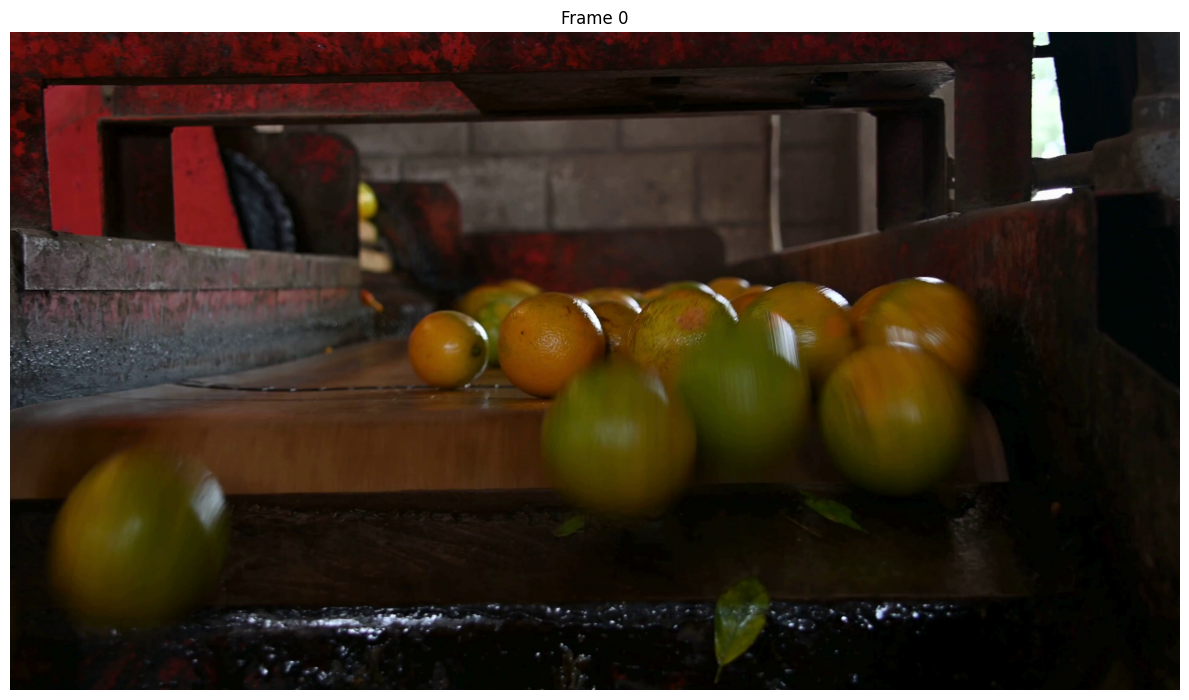

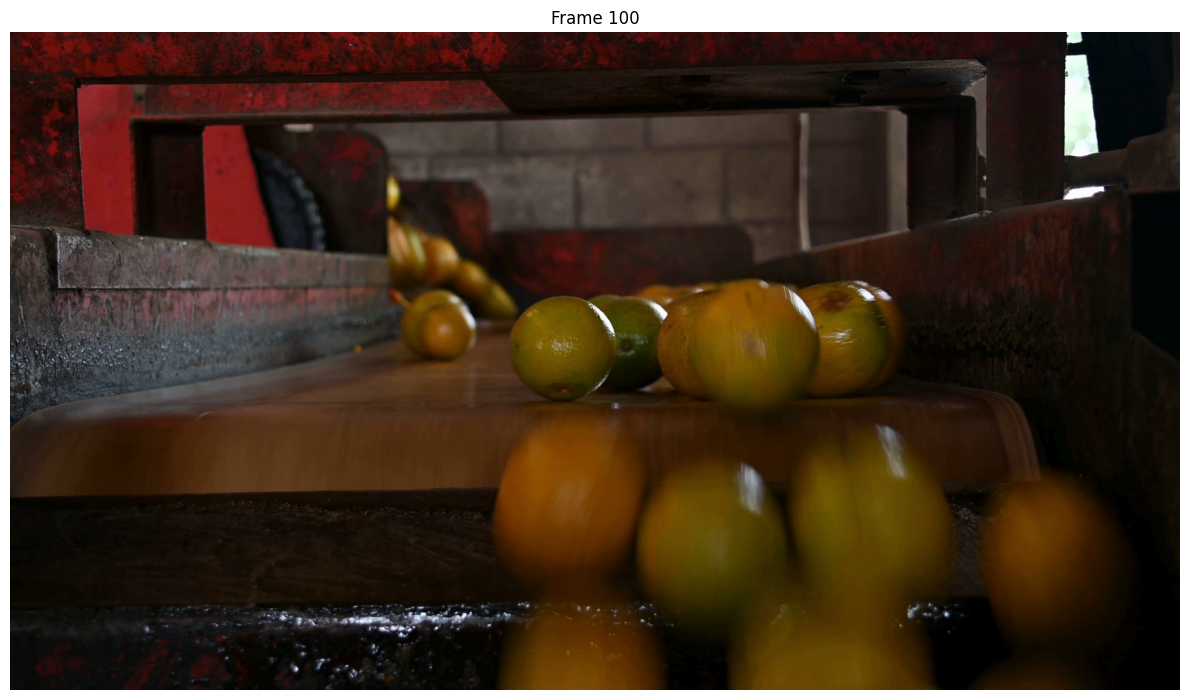

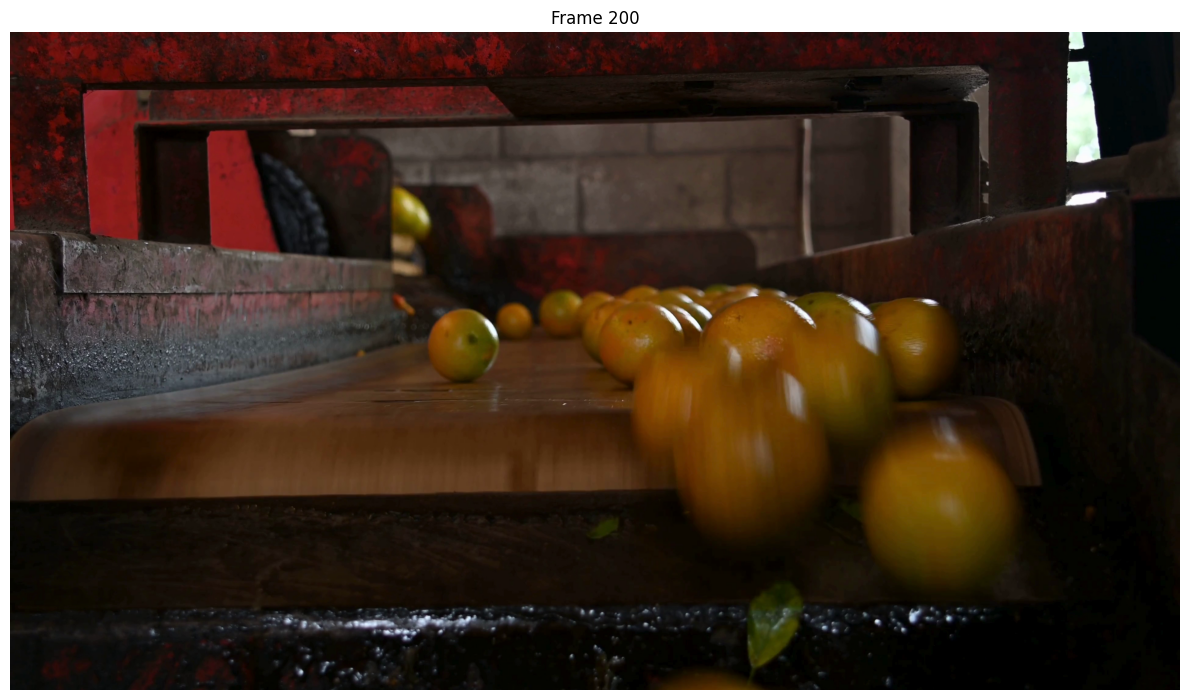

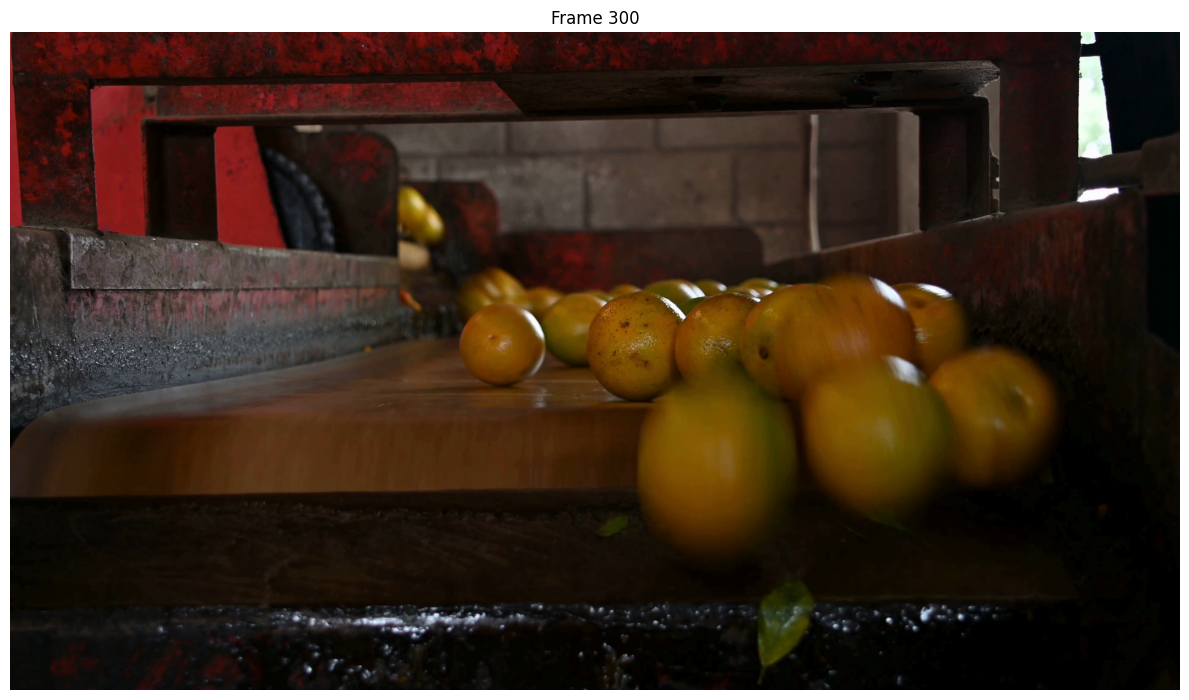

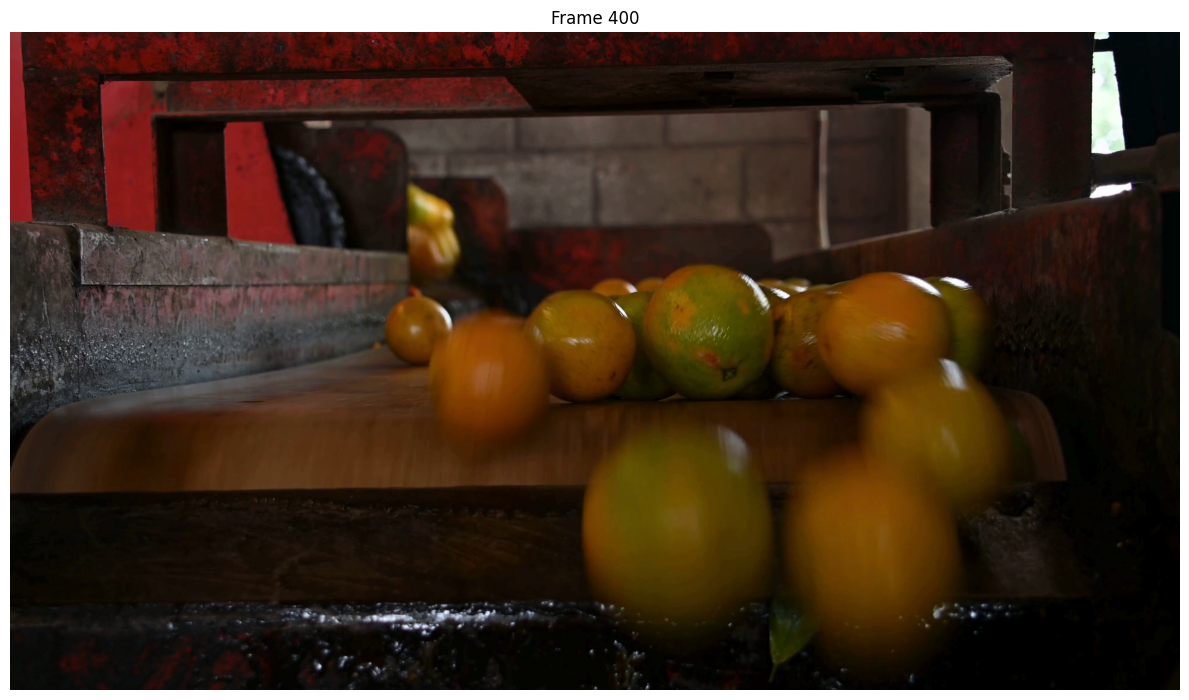

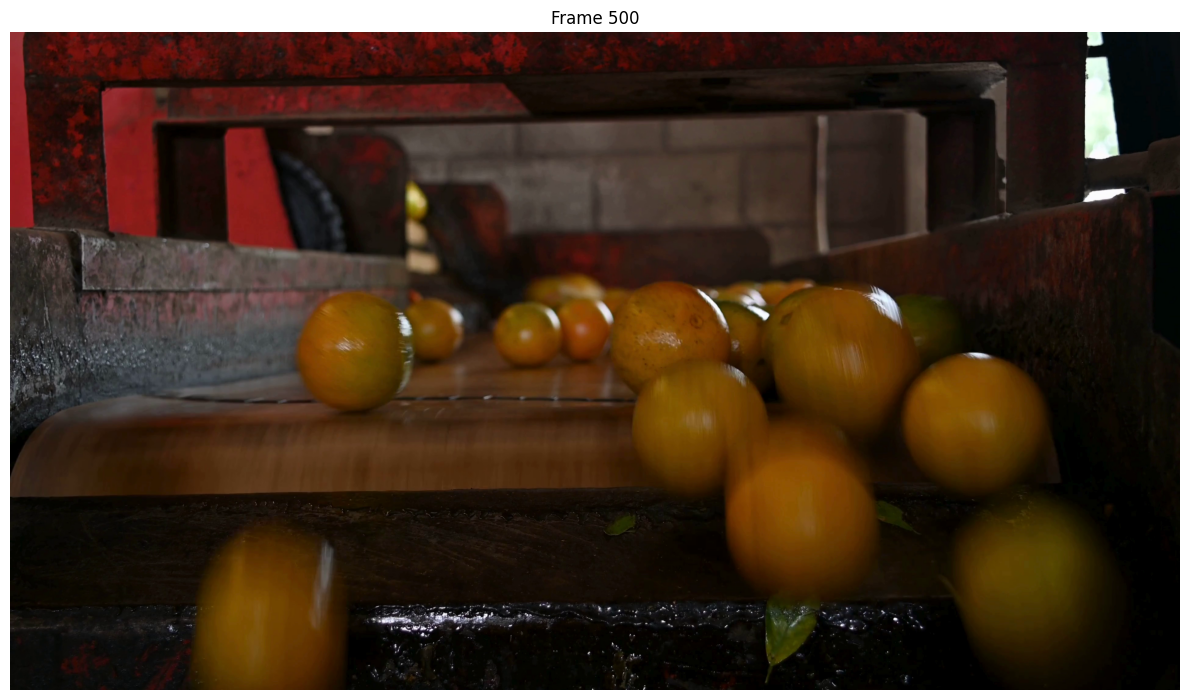

In [16]:
video_path = r"fruits_on_conveyor_video\sample1.mp4"

frame_no = [0, 100, 200, 300, 400, 500]

for frame in frame_no:
    extract_nth_frame(video_path, frame)

## Helper: Interactive ROI Selector
Define a function to interactively draw a polygon ROI on a video frame.

In [ ]:
def get_polygon_points(video_path, frame_no=0):
    """
    Draw a polygon on a video frame using OpenCV interactive UI.
    
    Controls:
    - Left-click: Add point to polygon
    - Right-click: Finish polygon (minimum 3 points)
    - Press 'r': Reset and start over
    - Press 'c': Complete polygon (same as right-click)
    - Press 'Esc': Cancel and exit
    
    Parameters:
    -----------
    video_path : str
        Path to the video file
    frame_no : int
        Frame number to extract (default: 0)
    
    Returns:
    --------
    list : List of polygon points [(x1, y1), (x2, y2), ...]
           Returns None if drawing failed or cancelled
    
    Example:
    --------
    >>> polygon = get_polygon_points("video.mp4", frame_no=100)
    >>> print(polygon)
    [(100, 200), (300, 200), (300, 400), (100, 400)]
    """
    
    # Extract frame
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error: Could not open video {video_path}")
        return None
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"❌ Error: Could not read frame {frame_no}")
        return None
    
    # State variables
    points = []
    drawing_complete = False
    frame_copy = frame.copy()
    
    # Mouse callback function
    def mouse_callback(event, x, y, flags, param):
        nonlocal points, drawing_complete
        
        # Left click - add point
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
            print(f"✓ Point {len(points)}: ({x}, {y})")
        
        # Right click - finish polygon
        elif event == cv2.EVENT_RBUTTONDOWN:
            if len(points) >= 3:
                drawing_complete = True
                print(f"✓ Polygon complete: {len(points)} points")
            else:
                print(f"⚠ Need at least 3 points (currently have {len(points)})")
    
    # Create window
    window_name = "Draw Polygon Perimeter"
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.setMouseCallback(window_name, mouse_callback)
    
    # Print instructions
    print("\n" + "="*70)
    print("POLYGON DRAWING - INTERACTIVE UI")
    print("="*70)
    print("  Left-click:  Add point to polygon")
    print("  Right-click: Finish polygon (minimum 3 points)")
    print("  Press 'r':   Reset and start over")
    print("  Press 'c':   Complete polygon")
    print("  Press 'Esc': Cancel and exit")
    print("="*70 + "\n")
    
    while True:
        # Create display frame
        display_frame = frame_copy.copy()
        
        # Draw all points
        for i, point in enumerate(points):
            # Draw point
            cv2.circle(display_frame, point, 6, (0, 255, 0), -1)
            cv2.circle(display_frame, point, 8, (255, 255, 255), 2)
            
            # Add point number
            cv2.putText(display_frame, str(i+1), 
                       (point[0] + 12, point[1] - 12),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(display_frame, str(i+1), 
                       (point[0] + 12, point[1] - 12),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)
        
        # Draw lines between consecutive points
        if len(points) > 1:
            for i in range(len(points) - 1):
                cv2.line(display_frame, points[i], points[i+1], (0, 255, 0), 2)
        
        # Draw closing line and fill if polygon is complete or has 3+ points
        if len(points) >= 3:
            # Draw closing line
            cv2.line(display_frame, points[-1], points[0], (0, 255, 0), 2)
            
            # Fill polygon with semi-transparent overlay
            overlay = display_frame.copy()
            pts = np.array(points, dtype=np.int32)
            cv2.fillPoly(overlay, [pts], (0, 255, 0))
            cv2.addWeighted(overlay, 0.3, display_frame, 0.7, 0, display_frame)
        
        # Add status text at the top
        status_text = f"Points: {len(points)}"
        if drawing_complete:
            status_text = f"COMPLETE - {len(points)} points (Press any key to exit)"
            cv2.rectangle(display_frame, (5, 5), (750, 45), (0, 200, 0), -1)
        else:
            cv2.rectangle(display_frame, (5, 5), (600, 45), (0, 0, 0), -1)
        
        cv2.putText(display_frame, status_text, (15, 32),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        
        # Show frame
        cv2.imshow(window_name, display_frame)
        
        # Handle keyboard input
        key = cv2.waitKey(1) & 0xFF
        
        # Esc - cancel
        if key == 27:
            print("❌ Cancelled by user")
            cv2.destroyAllWindows()
            return None
        
        # 'r' - reset
        elif key == ord('r') or key == ord('R'):
            points = []
            drawing_complete = False
            print("🔄 Reset - draw a new polygon")
        
        # 'c' - complete
        elif key == ord('c') or key == ord('C'):
            if len(points) >= 3:
                drawing_complete = True
                print(f"✓ Polygon complete: {len(points)} points")
            else:
                print(f"⚠ Need at least 3 points (currently have {len(points)})")
        
        # Exit if drawing is complete
        if drawing_complete:
            cv2.waitKey(1500)  # Show final result for 1.5 seconds
            break
    
    cv2.destroyAllWindows()
    
    if len(points) < 3:
        print(f"⚠ No valid polygon drawn (need at least 3 points)")
        return None
    
    print(f"\n✅ Polygon saved with {len(points)} vertices")
    print(f"Coordinates: {points}\n")
    return points


## Define Region of Interest
Launch the interactive tool to define the polygon ROI on a selected frame.

In [ ]:
perimeter_polygon = get_polygon_points(video_path, 50)


POLYGON DRAWING - INTERACTIVE UI
  Left-click:  Add point to polygon
  Right-click: Finish polygon (minimum 3 points)
  Press 'r':   Reset and start over
  Press 'c':   Complete polygon
  Press 'Esc': Cancel and exit

✓ Point 1: (0, 1485)
✓ Point 2: (3838, 1429)
✓ Point 3: (3835, 2153)
✓ Point 4: (5, 2158)
✓ Polygon complete: 4 points

✅ Polygon saved with 4 vertices
Coordinates: [(0, 1485), (3838, 1429), (3835, 2153), (5, 2158)]



## Helper: Annotate ROI
Define a function to verify the selected ROI by overlaying it on the frame.

In [17]:
def annotate_frame_with_polygon(video_path, frame_number, polygon_coords):
    """
    Annotate a specific video frame with a polygon region.
    
    Parameters:
    -----------
    video_path : str
        Path to the video file.
    frame_number : int
        The frame number to extract and annotate.
    polygon_coords : list
        List of (x, y) tuples defining the polygon vertices.
        Example: [(2, 2150), (1262, 1348), (3838, 1402), (3838, 2155), (15, 2158)]
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Error: Could not read frame {frame_number}")
        return
    # Create a copy for drawing
    annotated_frame = frame.copy()
    
    # Convert polygon coordinates to numpy array
    pts = np.array(polygon_coords, np.int32)
    pts = pts.reshape((-1, 1, 2))
    
    # Draw polygon: Magenta color, thickness 5
    cv2.polylines(annotated_frame, [pts], isClosed=True, color=(255, 0, 255), thickness=5)
    
    # Optional: Fill polygon with semi-transparent overlay
    overlay = annotated_frame.copy()
    cv2.fillPoly(overlay, [pts], (255, 0, 255))
    cv2.addWeighted(overlay, 0.2, annotated_frame, 0.8, 0, annotated_frame)
    # Convert to RGB for matplotlib display
    frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(frame_rgb)
    plt.title(f"Frame {frame_number} with ROI")
    plt.axis('off')
    plt.show()

## Verify ROI Annotation
Display the frame with the defined polygon overlay to verify accuracy.

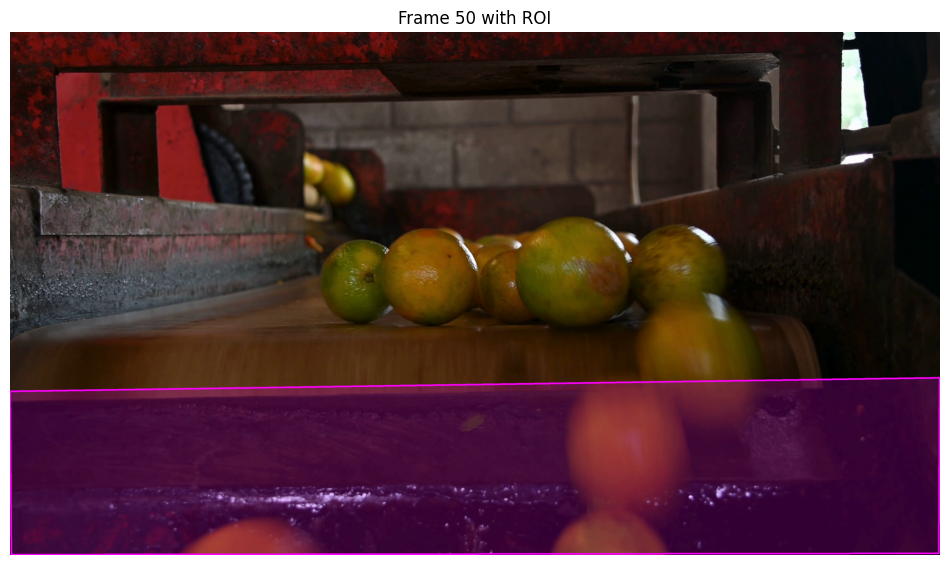

In [19]:
perimeter_polygon = [(0, 1485), (3838, 1429), (3835, 2153), (5, 2158)]
annotate_frame_with_polygon(video_path, 50, perimeter_polygon)

# FruitsCounter Implementation Logic

The `FruitsCounter` class encapsulates the logic for real-time fruit tracking and counting within a defined polygonal zone. It combines object detection, object tracking, and geometric logic to maintain an accurate count.

### 🔑 Key Components

*   **Initialization (`__init__`)**:
    *   Loads the trained `RT-DETR` model.
    *   Sets up the `region_polygon` (the counting zone).
    *   Initializes a set `counted_ids` to track unique, already-counted fruits.
    *   Configures visual styles (font, colors, thickness).

### 🛠️ Core Methods

1.  **`process_frame(frame)`**:
    *   **Tracking**: Runs the model on the frame to get bounding boxes and track IDs.
    *   **Counting Logic**: Iterates through tracks, calculates centroids, and checks if they fall inside the polygon using `point_in_polygon`. New IDs inside the zone are added to the count.
    *   **Visualization**: diverse calls to drawing methods to overlay boxes, the polygon, and the counter.

2.  **`point_in_polygon(point, polygon)`**:
    *   Implements the **Ray Casting algorithm** to mathematically determine if a point (fruit centroid) lies inside the arbitrary polygon shape.

3.  **`count_fruits(source_path, output_path)`**:
    *   The main driver function. Opens the input video, processes it frame-by-frame, and saves the annotated result to a new video file.

4.  **`Visualization Helpers`**:
    *   `draw_detections`: Draws bounding boxes and centroids (color-coded based on inside/outside status).
    *   `draw_counter`: Renders the polished "Count" overlay in the top-right corner.

In [21]:
class FruitsCounter:
    def __init__(
        self,
        model_path: str = r"runs\detect\train\weights\best.pt",
        conf_thres: float = 0.25,
        # iou_thres: float = 0.45,
        line_thickness: int = 3,
        random_seed: Optional[int] = 42,
        region_polygon: List[Tuple[int, int]] = None,
    ):
        self.model_path = Path(model_path)
        if not self.model_path.exists():
            raise FileNotFoundError(f"Model file not found at {self.model_path}")

        self.conf_thres = conf_thres
        # self.iou_thres = iou_thres
        self.line_thickness = line_thickness
        self.random_seed = random_seed
        self.region_polygon = region_polygon

        if random_seed is not None:
            random.seed(random_seed)

        print(f"Model loaded from {self.model_path}")
        self.model = RTDETR(str(self.model_path))
        
        self.track_colors: Dict[int, Tuple[int, int, int]] = {}
        self.counted_ids = set()

        self.counter_font = cv2.FONT_HERSHEY_SIMPLEX
        self.counter_font_scale = 5.0
        self.counter_font_thickness = 4
        self.counter_padding = 25
    
    @staticmethod
    def generate_random_color() -> Tuple[int, int, int]:
        """
        Generate a random vivid BGR color using HSV color space.
        
        Returns:
            Tuple of (B, G, R) values.
        """
        h = random.randint(0, 179)
        s = random.randint(180, 255)
        v = random.randint(180, 255)
        
        hsv_color = np.array([[[h, s, v]]], dtype=np.uint8)
        bgr_color = cv2.cvtColor(hsv_color, cv2.COLOR_HSV2BGR)[0][0]
        return (int(bgr_color[0]), int(bgr_color[1]), int(bgr_color[2]))

    
    def get_track_color(self, track_id: int) -> Tuple[int, int, int]:
        """
        Get the color for a specific track ID, generating a new one if needed.
        
        Args:
            track_id: The unique track identifier.
        
        Returns:
            BGR color tuple for the track.
        """
        if track_id not in self.track_colors:
            self.track_colors[track_id] = self.generate_random_color()
        return self.track_colors[track_id]
        
    def reset_tracks(self):
        """Clear all stored track colors."""
        self.track_colors.clear()

    def draw_counter(self, frame: np.ndarray, count: int) -> np.ndarray:
        """
        Draw the count in the upper right corner of the frame.
        
        Args:
            frame: Input BGR frame.
            count: Number of detected objects in the frame.
        
        Returns:
            Frame with counter overlay.
        """
        height, width = frame.shape[:2]
        count_text = f"Count: {count}"
        
        # Get text size for positioning
        (text_width, text_height), baseline = cv2.getTextSize(
            count_text, 
            self.counter_font, 
            self.counter_font_scale, 
            self.counter_font_thickness
        )
        
        # Position in upper right corner with padding
        text_x = width - text_width - self.counter_padding
        text_y = text_height + self.counter_padding
        
        # Background rectangle coordinates
        bg_x1 = text_x - 15
        bg_y1 = text_y - text_height - 15
        bg_x2 = width - self.counter_padding + 15
        bg_y2 = text_y + baseline + 10
        
        # Draw semi-transparent background
        overlay = frame.copy()
        cv2.rectangle(overlay, (bg_x1, bg_y1), (bg_x2, bg_y2), (0, 0, 0), -1)
        cv2.addWeighted(overlay, 0.7, frame, 0.3, 0, frame)
        
        # Draw border around counter
        cv2.rectangle(frame, (bg_x1, bg_y1), (bg_x2, bg_y2), (255, 255, 255), 2)
        
        # Draw count text
        cv2.putText(
            frame, count_text, (text_x, text_y),
            self.counter_font, self.counter_font_scale,
            (255, 255, 255), self.counter_font_thickness, cv2.LINE_AA
        )
        
        return frame

    @staticmethod
    def point_in_polygon(point, polygon):
        """
        Check if a point is inside a polygon using ray casting algorithm.
    
        Parameters:
        -----------
        point : tuple
            Point coordinates (x, y)
        polygon : list
            List of polygon vertices [(x1, y1), (x2, y2), ...]
    
        Returns:
        --------
        bool : True if point is inside polygon, False otherwise
        """
        x, y = point
        n = len(polygon)
        inside = False

        p1x, p1y = polygon[0]
        for i in range(1, n + 1):
            p2x, p2y = polygon[i % n]
            if y > min(p1y, p2y):
                if y <= max(p1y, p2y):
                    if x <= max(p1x, p2x):
                        if p1y != p2y:
                            xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1x == p2x or x <= xinters:
                            inside = not inside
            p1x, p1y = p2x, p2y
    
        return inside

    def get_centroid(self, box: List[int]) -> Tuple[int, int]:
        """
        Calculate the centroid of a bounding box.
    
        Parameters:
        -----------
        box : list
            Bounding box coordinates [x1, y1, x2, y2]
    
        Returns:
        --------
        tuple : (x, y) coordinates of the centroid
        """
        x1, y1, x2, y2 = box
        return (x1 + x2) // 2, (y1 + y2) // 2

    def draw_detections(
        self, 
        frame: np.ndarray, 
        boxes: np.ndarray, 
        track_ids: List[int]
    ) -> np.ndarray:
        """
        Draw bounding boxes for detected objects.
        
        Args:
            frame: Input BGR frame.
            boxes: Array of bounding box coordinates (x1, y1, x2, y2).
            track_ids: List of track IDs corresponding to each box.
        
        Returns:
            Frame with drawn bounding boxes.
        """
        for box, track_id in zip(boxes, track_ids):
            color = self.get_track_color(track_id)
            x1, y1, x2, y2 = map(int, box[:4])

            centroid = self.get_centroid([x1, y1, x2, y2])

            is_inside = False
            if self.region_polygon:
                if self.point_in_polygon(centroid, self.region_polygon):
                    is_inside = True
            
            # Draw bounding box (no label)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, self.line_thickness)

            # Draw centroid
            centroid_color = (0, 255, 0) if is_inside else (0, 0, 255)
            cv2.circle(frame, centroid, 10, centroid_color, -1)
        
        return frame

    def process_frame(
        self,
        frame: np.ndarray,
    ) -> Tuple[np.ndarray, int]:
        """
        Process a single frame: track objects, count if in polygon, draw detections. 
        """
        results = self.model.track(frame, persist=True, conf=self.conf_thres, verbose=False)
        
        current_count = len(self.counted_ids)

        if results and results[0].boxes:
            boxes = results[0].boxes.xyxy.cpu().numpy()

            if results[0].boxes.id is not None:
                track_ids = results[0].boxes.id.int().cpu().tolist()

                for box, track_id in zip(boxes, track_ids):
                    x1, y1, x2, y2 = map(int, box[:4])
                    centroid = self.get_centroid([x1, y1, x2, y2])

                    if self.region_polygon:
                        if self.point_in_polygon(centroid, self.region_polygon):
                            if track_id not in self.counted_ids:
                                self.counted_ids.add(track_id)

                frame = self.draw_detections(frame, boxes, track_ids)

        # Draw polygon if defined
        if self.region_polygon:
            pts = np.array(self.region_polygon, np.int32)
            pts = pts.reshape((-1, 1, 2))
            
            # Draw purple overlay
            overlay = frame.copy()
            cv2.fillPoly(overlay, [pts], (247, 3, 255))
            cv2.addWeighted(overlay, 0.4, frame, 0.8, 0, frame)
            
            # Draw border
            cv2.polylines(frame, [pts], True, (255, 0, 0), 10)

        frame = self.draw_counter(frame, len(self.counted_ids))

        # Draw total count
        return frame, len(self.counted_ids)
    
    def count_fruits(self, source_path: str, output_path: str = "output_counts.mp4"):
        """
        Process video to count fruits.
        """
        cap = cv2.VideoCapture(source_path)
        if not cap.isOpened():
             print(f"Error opening video file {source_path}")
             return

        # Get video properties
        width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps    = cap.get(cv2.CAP_PROP_FPS)

        # Output video writer
        out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
        
        frame_count = 0
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"Processing video: {source_path}")
        print(f"Output will be saved to: {output_path}")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            processed_frame, count = self.process_frame(frame)
            
            out.write(processed_frame)
            
            frame_count += 1
            if frame_count % 50 == 0:
                print(f"Processed {frame_count}/{total_frames} frames. Current Count: {count}")

        cap.release()
        out.release()
        print("Processing complete.")

In [22]:
region_polygon = [(0, 1485), (3838, 1429), (3835, 2153), (5, 2158)]

counter = FruitsCounter(region_polygon=region_polygon)

video_path = r"fruits_on_conveyor_video\sample1.mp4"
counter.count_fruits(video_path)

Model loaded from runs\detect\train\weights\best.pt
Processing video: fruits_on_conveyor_video\sample1.mp4
Output will be saved to: output_counts.mp4
Processed 50/666 frames. Current Count: 29
Processed 100/666 frames. Current Count: 51
Processed 150/666 frames. Current Count: 75
Processed 200/666 frames. Current Count: 96
Processed 250/666 frames. Current Count: 114
Processed 300/666 frames. Current Count: 137
Processed 350/666 frames. Current Count: 155
Processed 400/666 frames. Current Count: 171
Processed 450/666 frames. Current Count: 194
Processed 500/666 frames. Current Count: 217
Processed 550/666 frames. Current Count: 246
Processed 600/666 frames. Current Count: 264
Processed 650/666 frames. Current Count: 289
Processing complete.


---

## 👨‍💻 About Labellerr's Hands-On Learning in Computer Vision

Thank you for exploring this **Labellerr Hands-On Computer Vision Cookbook**! We hope this notebook helped you learn, prototype, and accelerate your vision projects.  
Labellerr provides ready-to-run Jupyter/Colab notebooks for the latest models and real-world use cases in computer vision, AI agents, and data annotation.

---
## 🧑‍🔬 Check Our Popular Youtube Videos

Whether you're a beginner or a practitioner, our hands-on training videos are perfect for learning custom model building, computer vision techniques, and applied AI:

- [How to Fine-Tune YOLO on Custom Dataset](https://www.youtube.com/watch?v=pBLWOe01QXU)  
  Step-by-step guide to fine-tuning YOLO for real-world use—environment setup, annotation, training, validation, and inference.
- [Build a Real-Time Intrusion Detection System with YOLO](https://www.youtube.com/watch?v=kwQeokYDVcE)  
  Create an AI-powered system to detect intruders in real time using YOLO and computer vision.
- [Finding Athlete Speed Using YOLO](https://www.youtube.com/watch?v=txW0CQe_pw0)  
  Estimate real-time speed of athletes for sports analytics.
- [Object Counting Using AI](https://www.youtube.com/watch?v=smsjBBQcIUQ)  
  Learn dataset curation, annotation, and training for robust object counting AI applications.
---

## 🎦 Popular Labellerr YouTube Videos

Level up your skills and see video walkthroughs of these tools and notebooks on the  
[Labellerr YouTube Channel](https://www.youtube.com/@Labellerr/videos):

- [How I Fixed My Biggest Annotation Nightmare with Labellerr](https://www.youtube.com/watch?v=hlcFdiuz_HI) – Solving complex annotation for ML engineers.
- [Explore Your Dataset with Labellerr's AI](https://www.youtube.com/watch?v=LdbRXYWVyN0) – Auto-tagging, object counting, image descriptions, and dataset exploration.
- [Boost AI Image Annotation 10X with Labellerr's CLIP Mode](https://www.youtube.com/watch?v=pY_o4EvYMz8) – Refine annotations with precision using CLIP mode.
- [Boost Data Annotation Accuracy and Efficiency with Active Learning](https://www.youtube.com/watch?v=lAYu-ewIhTE) – Speed up your annotation workflow using Active Learning.

> 👉 **Subscribe** for Labellerr's deep learning, annotation, and AI tutorials, or watch videos directly alongside notebooks!

---

## 🤝 Stay Connected

- **Website:** [https://www.labellerr.com/](https://www.labellerr.com/)
- **Blog:** [https://www.labellerr.com/blog/](https://www.labellerr.com/blog/)
- **GitHub:** [Labellerr/Hands-On-Learning-in-Computer-Vision](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)
- **LinkedIn:** [Labellerr](https://in.linkedin.com/company/labellerr)
- **Twitter/X:** [@Labellerr1](https://x.com/Labellerr1)

*Happy learning and building with Labellerr!*
